In [148]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [149]:
batch_size = 32
img_height = 180
img_width = 180


In [150]:
train_ds = tf.keras.utils.image_dataset_from_directory('CNNDaten/Train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 1051 files belonging to 3 classes.
Using 841 files for training.


In [151]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "CNNDaten/Valid",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 93 files belonging to 3 classes.


In [152]:
class_names = train_ds.class_names
print(class_names)


['Dosenoeffner', 'Flaschenoeffner', 'Korkenzieher']


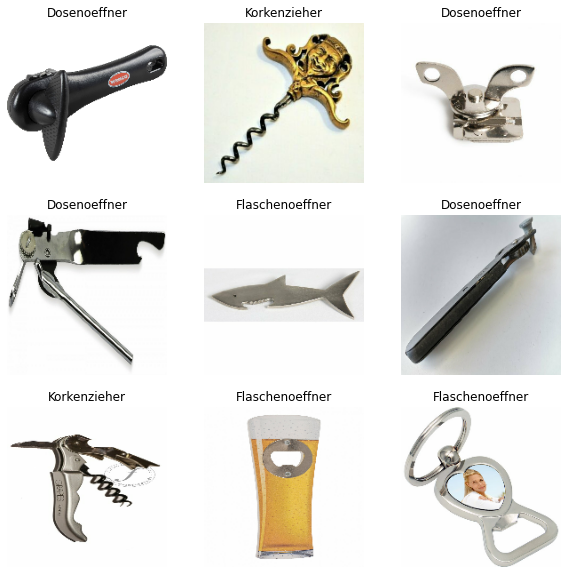

In [153]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [154]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 180, 180, 3)
(32,)


In [155]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [156]:
normalization_layer = layers.Rescaling(1./255)



In [157]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.09898343 1.0


In [158]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [159]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [160]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_17 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 45, 45, 64)       

In [161]:
from tensorflow.keras.callbacks import EarlyStopping

early = EarlyStopping(monitor="val_loss", patience=3)

epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=128,
  callbacks=[early]
)

Epoch 1/20
27/27 [==============================] - 10s 371ms/step - loss: 1.1669 - accuracy: 0.3817 - val_loss: 1.0882 - val_accuracy: 0.3871
Epoch 2/20
27/27 [==============================] - 9s 336ms/step - loss: 0.9740 - accuracy: 0.5137 - val_loss: 1.0033 - val_accuracy: 0.4086
Epoch 3/20
27/27 [==============================] - 10s 358ms/step - loss: 0.7785 - accuracy: 0.6504 - val_loss: 0.9051 - val_accuracy: 0.4946
Epoch 4/20
27/27 [==============================] - 10s 361ms/step - loss: 0.5775 - accuracy: 0.7741 - val_loss: 0.9172 - val_accuracy: 0.5591
Epoch 5/20
27/27 [==============================] - 10s 357ms/step - loss: 0.4122 - accuracy: 0.8442 - val_loss: 0.8650 - val_accuracy: 0.6344
Epoch 6/20
27/27 [==============================] - 10s 365ms/step - loss: 0.2862 - accuracy: 0.8977 - val_loss: 0.9328 - val_accuracy: 0.6774
Epoch 7/20
27/27 [==============================] - 10s 355ms/step - loss: 0.1904 - accuracy: 0.9334 - val_loss: 0.9898 - val_accuracy: 0.6882


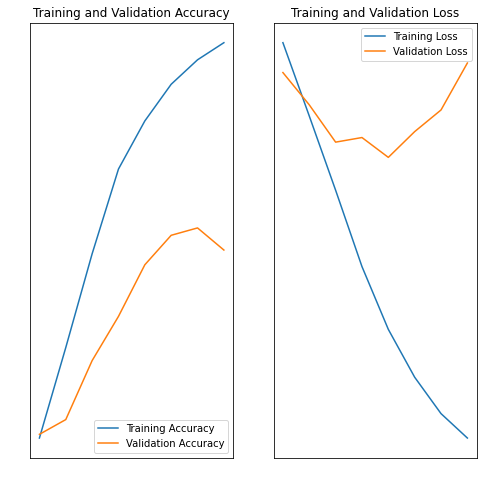

In [162]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.tick_params(axis='x',colors='white')
plt.tick_params(axis='y',colors='white')
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.tick_params(axis='x',colors='white')
plt.tick_params(axis='y',colors='white')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
